# Analysis of threat reports
This notebook contains cells to analyse threat reports on the threats and actors they describe.

## Build initial threat- and actor list from spreadsheet

In [3]:
import pandas as pd
import numpy as np

file = "Threat reports.xlsx"
reports = pd.read_excel(file,sheet_name="Threat reports")

In [4]:
# Function to transform a list to unique (case insensitive) values
def unique(lst):
    result=[]
    marker = set()

    for l in lst:
        ll = l.lower()
        if ll not in marker:   # test presence
            marker.add(ll)
            result.append(l)   # preserve order

    return result

# Build the lists
year = 2021

# Filter on one year
reports=reports[reports['reported year'] == year]

report_threats = reports['threats'].dropna().apply(lambda x: x.split(", "))
threats_mentions = pd.Series([t for l in report_threats for t in l if t != ""])
threatlist = unique(threats_mentions)

report_actors = reports['actors'].dropna().apply(lambda x: x.split(", "))
actor_mentions = pd.Series([t for l in report_actors for t in l if t != ""])
actorlist = unique(actor_mentions)

print(len(threatlist),"Threats:\n",threatlist)
print(len(actorlist),"Threat actors:\n",actorlist)

42 Threats:
 ['ransomware', 'crypto malware', 'scams', 'adware', 'fleeceware', 'phishing', 'coinminers', 'information stealers', 'remote access trojan', 'technical support cams', 'rootkits', 'supply chain attack', 'remote code execution', 'business email compromise', 'brand abuse', 'data exposure on code repositories', 'targeted threats on remote work', 'DDoS', 'proxy shell', 'account compromise', 'system compromise', 'botnet', 'server access', 'credential harvesting', 'misconfiguration', 'malicious insider', 'vulnerability exploitation', 'brute force', 'password spraying', 'banking trojan', 'network pivot', 'network infrastructure compromise', 'local code execution', 'use of stolen credentials', 'pretexting', 'misdelivery', 'C2', 'backdoor', 'privilege abuse', 'capture app data', 'trojan', 'denial of service']
48 Threat actors:
 ['LuckyMouse', 'Mustang Panda', 'Gamaredon', 'Promethium', 'HAFNIUM', 'Wizard Spider', 'Bitwise Spider', 'Carbon Spider', 'Pinchy Spider', 'Pioneer Kitten', '

## Scan PDFs on threats and actors

#### Initialize dictionaries

In [5]:
import PyPDF2
import os

report_folder = "reports\\2021"
report_list = [file for file in os.listdir(report_folder) if file.endswith(".pdf")]

## Init threat dictionary to count occurences of threats per report
report_threats = {}  
report_actors = {}

for i in report_list:
    threat_dict = {}
    for j in threatlist:
        threat_dict[j] = 0    
    report_threats[i] = threat_dict

for i in report_list:
    actor_dict = {}
    for k in actorlist:
        actor_dict[k] = 0
    report_actors[i] = actor_dict

#### Text preprocessing
Convert to lowercase and remove punctuations. I have written a part to remove stopwords and tokenize the text, but with writing sentence analysis later this is left out for now as stopwords might be useful.

In [6]:
import nltk
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words('english')

def preprocess(text):
    text_lower = re.sub(r"[^a-zA-Z0-9 ]","",text.lower())
    return text_lower
    # tokens = word_tokenize(text_lower)
    # keywords = [word for word in tokens if not word in stop_words]
    # return keywords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.winters\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a.winters\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Scan threat report PDFs
Threat reports are scanned on the threats and actors defined in the spreadsheet. The number of occurences is noted.

In [15]:
text_dict = {}

for file in report_list:
    print("Processing: ",file)

    reader = PyPDF2.PdfFileReader(report_folder+"\\"+file,strict=False)
    raw_text = ""
    for page_number in range(0, reader.numPages):
        page = reader.getPage(page_number)
        raw_text += page.extractText()
    text_dict[file] = {"raw": raw_text, "processed": preprocess(raw_text)}

Processing:  Blackberry.pdf
Processing:  Bugcrowd.pdf
Processing:  Crowdstrike.pdf
Processing:  CTM360.pdf
Processing:  Deepwatch.pdf
Processing:  ENISA.pdf
Processing:  Fortinet-2021H1.pdf
Processing:  Fortinet-2021H2.pdf
Processing:  IBM.pdf
Processing:  Microsoft.pdf
Processing:  PaloAltoNetworks.pdf
Processing:  Rapid7.pdf
Processing:  Verizon.pdf


#### Convert to .txt for testing NLP tools

In [19]:
from pathlib import Path, PureWindowsPath

txt_filepath = Path("reports_txt/"+str(year))

for file,values in text_dict.items():
    text = values["raw"]
    filenm = file.replace(".pdf",".txt")
    to_write = txt_filepath / filenm
    with open(to_write,'w',encoding='utf-8') as f:
        f.write(text)
     

In [6]:
# Count occurences of terms in reports
for file,values in text_dict.items():
    text = values["processed"]
    for threat in threatlist:
        report_threats[file][threat] = text.count(threat.lower())
    for actor in actorlist:
        report_actors[file][actor] = text.count(actor.lower()) 

threats_df = pd.DataFrame(report_threats)
actors_df = pd.DataFrame(report_actors)

#### Merge synonyms

In [7]:
# Get synonyms of threat actors from ETDA
import pandas as pd
import json
import requests

# Retrieve data in json format
etda_actors = requests.get('https://apt.etda.or.th/cgi-bin/getcard.cgi?g=all&o=j')
data = etda_actors.json()

actor_list = []

for actor in data['values']:
    actor_dict = {}
    actor_dict['actor'] = actor['actor']
    actor_dict['alternate_names'] = [x['name'] for x in actor['names']]
    actor_list.append(actor_dict)

synonym_df = pd.DataFrame(actor_list)

In [8]:
# Transpose dataframe so that the actors are columns
actors_df_transposed = actors_df.T

# Function to find synonyms of actors and sum the results
def sum_synonyms(df, synonyms):
    summed_df = df
    word_matches = {}
    for actor in df.columns:
        lst = []
        for _, row in synonyms.iterrows():
            keyname = row['actor']
            synonym = row['alternate_names']
            match = [x for x in synonym if actor == x]
            if actor == keyname or match:
                match = ' '.join(map(str, match))
                try:
                    word_matches[keyname].append(match)
                except:
                    word_matches[keyname] = [match]

    # Combine results of alternative names
    for keyname, matches in word_matches.items():
        summed_df[keyname] = df[matches].sum(axis=1)
    
    # Return the summed columns
    return summed_df[list(word_matches.keys())]

actors_df = sum_synonyms(actors_df_transposed,synonym_df).T


### Sentence context analysis.
> **_NOTE:_**  This sections mentions threats, but in the context of this work _threats_ means both threats and threat actors.

Currently, the reports are being scanned using the lists from the spreadsheet. It could be that a threat is mentioned in a report but not included in this initial list. Extracting the words in a sentence that surround a term can be used to look for more potential mentions in the report. 

A small experiment is done to find the right amount of words preceding the term.

The text is processed as follows:
- Find location of the term. Get the 3,4,5 words preceding it.
- Find commonalities in the extracted words.
- 

One limitation using this method is that often in threat reports, threats are listed in graphs. In such a graph the threats are often not mentioned in a sentence, but as a single term. Since these graphs are good indicators of mentioned threats, it is interesting to find a way to extract threats from graphs in threat reports.

In [9]:
# TODO
preceding = []
nr_prec = 3

testtext = text_dict["Blackberry.pdf"]["processed"]

## Statistics

### Normalize data
Since the absolute number of hits cannot be compared between reports, due to differences in report lengths and the number of words, the data is normalized using the minmax normalization.

In [10]:
def normalize(df):
    return (df-df.min())/(df.max()-df.min())

normalized_threats = normalize(threats_df)

normalized_actors = normalize(actors_df)


## Plot graphs
Leave out the threats and actors with no occurences.

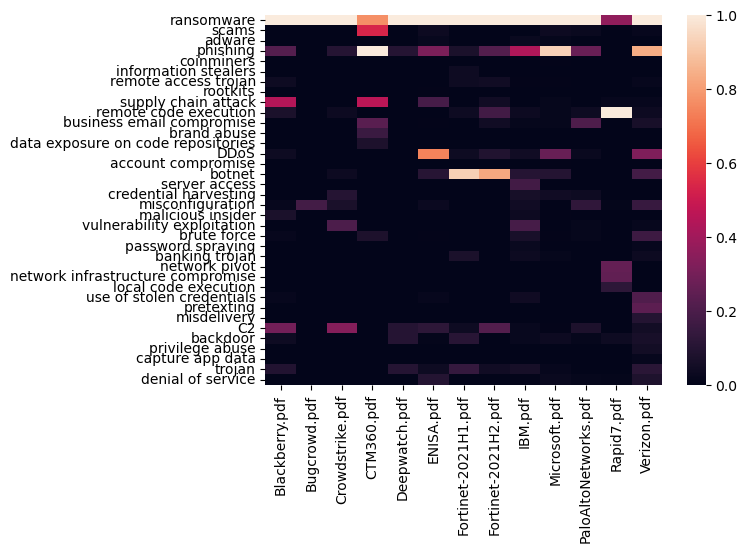

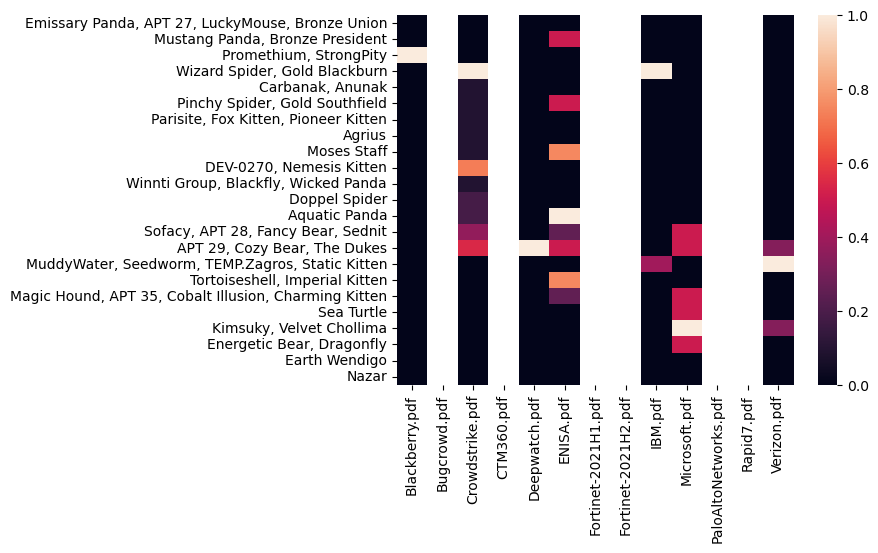

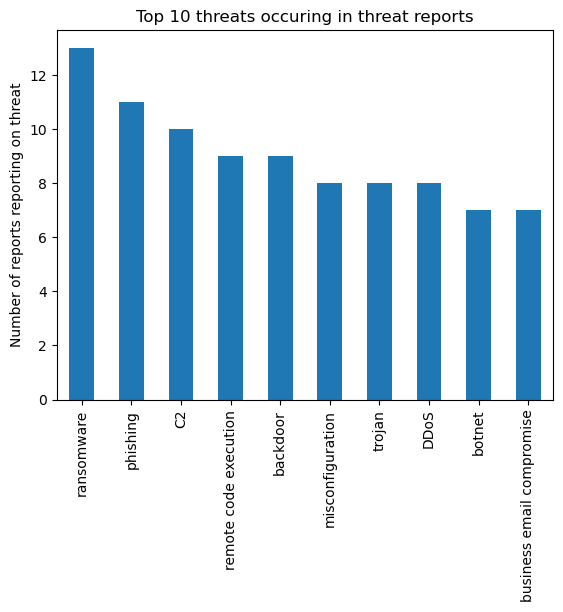

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure()
sns.heatmap(normalized_threats.loc[~(normalized_threats==0).all(axis=1)], yticklabels=True)

plt.figure()
sns.heatmap(normalized_actors.loc[~(normalized_actors==0).all(axis=1)], yticklabels=True)


fig = plt.figure()
threat_occurences = normalized_threats.gt(0).sum(axis=1)
threat_occurences.sort_values(inplace=True)
threat_occurences.nlargest(10).plot(kind="bar",title="Top 10 threats occuring in threat reports")
plt.ylabel("Number of reports reporting on threat")
plt.show()